# **Method 2**

In [7]:
import pandas as pd
df = pd.read_csv('/creditcard.csv')

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

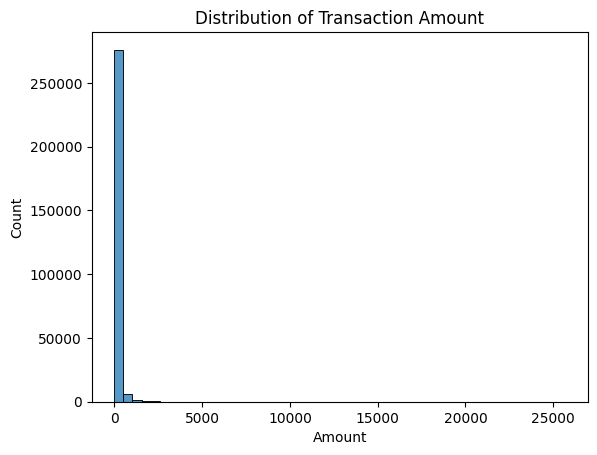

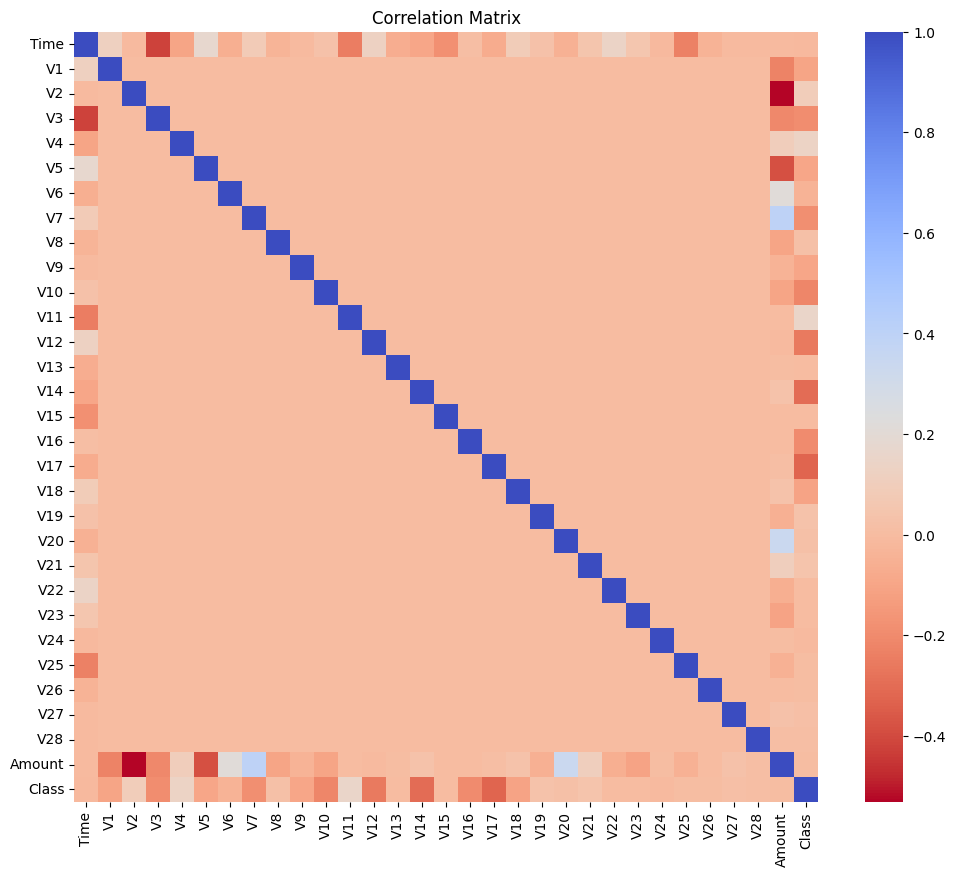

In [8]:
print(df.head())
print(df.info())
print(df['Class'].value_counts()) # Observe imbalance
# Plot distributions of Amount, Time (or V features)
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df['Amount'], bins=50)
plt.title('Distribution of Transaction Amount')
plt.show()
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm_r', annot=False) # Annot=False for many features
plt.title('Correlation Matrix')
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # Requires pip install imbalanced-learn

# Drop Time if not using it for feature engineering
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

# Scale 'Amount'
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

# Split data (stratified to maintain class ratio in train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to training data only
print("Before SMOTE, training set shape:", X_train.shape, y_train.value_counts())
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE, training set shape:", X_train_res.shape, y_train_res.value_counts())

Before SMOTE, training set shape: (199364, 29) Class
0    199020
1       344
Name: count, dtype: int64
After SMOTE, training set shape: (398040, 29) Class
0    199020
1    199020
Name: count, dtype: int64


Confusion Matrix:
 [[85292     3]
 [   44   104]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.70      0.82       148

    accuracy                           1.00     85443
   macro avg       0.99      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC Score: 0.9376291820280331
Precision-Recall AUC: 0.827927325586495


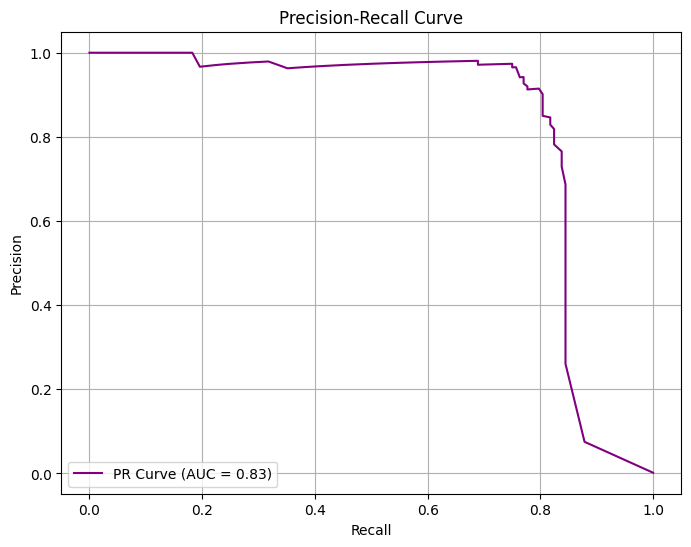

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # 'balanced' handles imbalance
# Or train on SMOTE-resampled data: model.fit(X_train_res, y_train_res)
model.fit(X_train, y_train) # Using class_weight here as an alternative to SMOTE

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] # Probability of being fraud

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Precision-Recall Curve for better insight into imbalanced data
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()